<a href="https://colab.research.google.com/github/ajay1808/Chloropleth_Maps/blob/master/Motor_Vehicle_Safety_in_Manhattan_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Motor Vehicle Safety in Manhattan Project

New York is a busy city. It is well known that motor accidents happen everyday in New York. But are there some times of the day when it is less frequent? Some days of the week? or certain months?

In this project we will not depict the accidents that have happened in new york till now but predict and display the  street map of manhattan with the likelihood of each road having an accident. Thus displaying the street safety of different roads and the borough across different time periods in the present and the future.

#### Installing Libraries

In [1]:
{
    "tags": [
        "hide-output"
    ]
}
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install osmnx;     

In [ ]:
pip install matplotlib==3.1.3

#### Import all required libraries

In [4]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import numpy as np
from datetime import datetime as dt
from itertools import product
from matplotlib import pyplot as plt

#### Fetch data from the data sources

Let us import the boroughs dataset from a geojson file downloaded from [NYC OpenData](https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm])

In [5]:
boroughs = gpd.read_file("/content/Borough Boundaries.geojson")
boroughs.head()

,boro_code,boro_name,shape_area,shape_leng,geometry
0,4,Queens,3040205594.95,900269.280485,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."
1,3,Brooklyn,1934167333.21,728477.954082,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ..."
2,5,Staten Island,1623631283.36,325924.002076,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
3,1,Manhattan,636620785.519,359993.126318,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
4,2,Bronx,1187193588.79,463868.599917,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."


Now let us import data on the last 30000 Motor accidents in New York from [NYC OpenData]('https://data.cityofnewyork.us/resource/h9gi-nx95')

In [6]:
raw_data = pd.read_csv('https://data.cityofnewyork.us/resource/h9gi-nx95.csv?$limit=30000&$offset=0&$order=crash_date%20DESC')
raw_data.head()

,crash_date,crash_time,borough,zip_code,latitude,longitude,location,on_street_name,off_street_name,cross_street_name,...,contributing_factor_vehicle_2,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,collision_id,vehicle_type_code1,vehicle_type_code2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5
0,2022-07-03T00:00:00.000,13:40,BROOKLYN,11203.0,40.640370,-73.93887,"\n, \n(40.64037, -73.93887)",NaN,NaN,622 EAST 40 STREET,...,Unspecified,NaN,NaN,NaN,4543320,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN
1,2022-07-03T00:00:00.000,16:32,MANHATTAN,10029.0,40.792686,-73.93941,"\n, \n(40.792686, -73.93941)",NaN,NaN,348 EAST 110 STREET,...,NaN,NaN,NaN,NaN,4543620,Sedan,NaN,NaN,NaN,NaN
2,2022-07-03T00:00:00.000,1:50,MANHATTAN,10039.0,40.822308,-73.93859,"\n, \n(40.822308, -73.93859)",7 AVENUE,WEST 146 STREET,NaN,...,Unspecified,Unspecified,NaN,NaN,4543191,Sedan,Sedan,Sedan,NaN,NaN
3,2022-07-03T00:00:00.000,20:27,BROOKLYN,11237.0,40.700245,-73.92089,"\n, \n(40.700245, -73.92089)",STANHOPE STREET,KNICKERBOCKER AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4543456,Sedan,NaN,NaN,NaN,NaN
4,2022-07-03T00:00:00.000,19:30,NaN,NaN,NaN,NaN,NaN,ORCHARD BEACH,ORCHARD BEACH ROAD,NaN,...,Other Vehicular,NaN,NaN,NaN,4543382,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN


#### Creating Street Network and Boundary Variables

Let us choose only Manhattan for simplicity as we have limited computing capacity

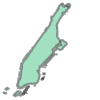

In [7]:
selection = boroughs['boro_name'] == "Manhattan"
boundary = boroughs.loc[selection]
boundary = boundary.geometry.squeeze()
boundary

Now let us create our street network

In [8]:
network_graph = ox.graph_from_polygon(polygon = boundary, network_type='drive')

From the network let us extract all the edges and their characteristics

In [9]:
edges = ox.graph_to_gdfs(network_graph, edges=True, nodes=False)
edges.head(3)

osmid               name  \
u        v        key                                                       
42421728 42432736 0                          195743153  Central Park West   
         42435337 0                          195743153  Central Park West   
         42421731 0    [420625565, 420625573, 5668966]  West 106th Street   

                         highway maxspeed  oneway   length  \
u        v        key                                        
42421728 42432736 0    secondary   25 mph   False   86.258   
         42435337 0    secondary   25 mph   False   85.345   
         42421731 0    secondary      NaN   False  138.033   

                                                                geometry  \
u        v        key                                                      
42421728 42432736 0    LINESTRING (-73.96004 40.79805, -73.95996 40.7...   
         42435337 0    LINESTRING (-73.96004 40.79805, -73.96011 40.7...   
         42421731 0    LINESTRING (-73.96004 40.79805, -73.96017 40.7...   

                      lanes  ref access bridge tunnel width junction  
u        v        key                                                 
42421728 42432736 0     NaN  NaN    NaN    NaN    NaN   NaN      NaN  
         42435337 0     NaN  NaN    NaN    NaN    NaN   NaN      NaN  
         42421731 0     NaN  NaN    NaN    NaN    NaN   NaN      NaN

Let us now isolate all the crashes in manhattan and create Month, Hour and Weekday columns because these 3 features are cyclic and potentially have a pattern.

#### Filtering Raw data with boundary variables



In [10]:
crashes = gpd.GeoDataFrame(
    raw_data,
    geometry=gpd.points_from_xy(raw_data.longitude,raw_data.latitude ),
    crs="epsg:4326",
)
edges_boundary = edges.unary_union.convex_hull
edges_boundary

selection = crashes.within(edges_boundary)
crashes_manhattan = crashes.loc[selection].reset_index(drop=True)
crashes_manhattan['Months'] = np.linspace(0,0,len(crashes_manhattan))
crashes_manhattan['Hours']= np.linspace(0,0,len(crashes_manhattan))
crashes_manhattan['Weekday'] = np.linspace(0,0,len(crashes_manhattan))
for i in range(len(crashes_manhattan)):
  crashes_manhattan['crash_date'][i] = (dt.strptime((crashes_manhattan['crash_date'][i][0:10] + crashes_manhattan['crash_time'][i]), '%Y-%m-%d%H:%M'))
  crashes_manhattan['Months'][i] = crashes_manhattan['crash_date'][i].month
  crashes_manhattan['Hours'][i] = crashes_manhattan['crash_date'][i].hour
  crashes_manhattan['Weekday'][i] = crashes_manhattan['crash_date'][i].weekday()
crashes_manhattan.head(3)

,crash_date,crash_time,borough,zip_code,latitude,longitude,location,on_street_name,off_street_name,cross_street_name,...,collision_id,vehicle_type_code1,vehicle_type_code2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,geometry,Months,Hours,Weekday
0,2022-07-03 16:32:00,16:32,MANHATTAN,10029.0,40.792686,-73.93941,"\n, \n(40.792686, -73.93941)",NaN,NaN,348 EAST 110 STREET,...,4543620,Sedan,NaN,NaN,NaN,NaN,POINT (-73.93941 40.79269),7.0,16.0,6.0
1,2022-07-03 01:50:00,1:50,MANHATTAN,10039.0,40.822308,-73.93859,"\n, \n(40.822308, -73.93859)",7 AVENUE,WEST 146 STREET,NaN,...,4543191,Sedan,Sedan,Sedan,NaN,NaN,POINT (-73.93859 40.82231),7.0,1.0,6.0
2,2022-07-03 00:54:00,0:54,NaN,NaN,40.785030,-73.94058,"\n, \n(40.78503, -73.94058)",FDR DRIVE,NaN,NaN,...,4542813,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,POINT (-73.94058 40.78503),7.0,0.0,6.0


In [11]:
num_crashes = len(crashes_manhattan)
print("Crashes in Manhattan: ",num_crashes)

Crashes in Manhattan:  5442


Now since we have the latitude and longitude of each and every crash, let us convert it to Open Street Map edges

In [12]:
%%time 
crash_edges = ox.distance.nearest_edges(network_graph, crashes_manhattan.geometry.x, crashes_manhattan.geometry.y);

CPU times: user 2min 29s, sys: 2.36 s, total: 2min 31s
Wall time: 2min 33s


Now in order to facilitate combining the data, let us create a unique key representing each edge. This unique key will be a combination of u,v and key which are used to identify each open streetmap edge.

In [13]:
u=[]
v=[]
key=[]
uvkey = []
for i in range(len(crashes_manhattan)):
  u.append(crash_edges[i][0])
  v.append(crash_edges[i][1])
  key.append(crash_edges[i][2])
  uvkey.append( str(crash_edges[i][0]) + " " + str(crash_edges[i][1]) + " " + str(crash_edges[i][2]))
crashes_manhattan['u'] = u
crashes_manhattan['v'] = v
crashes_manhattan['key'] = key
crashes_manhattan['uvkey'] = key

crashes_manhattan.head(3)


,crash_date,crash_time,borough,zip_code,latitude,longitude,location,on_street_name,off_street_name,cross_street_name,...,vehicle_type_code_4,vehicle_type_code_5,geometry,Months,Hours,Weekday,u,v,key,uvkey
0,2022-07-03 16:32:00,16:32,MANHATTAN,10029.0,40.792686,-73.93941,"\n, \n(40.792686, -73.93941)",NaN,NaN,348 EAST 110 STREET,...,NaN,NaN,POINT (-73.93941 40.79269),7.0,16.0,6.0,42434386,42434389,0,0
1,2022-07-03 01:50:00,1:50,MANHATTAN,10039.0,40.822308,-73.93859,"\n, \n(40.822308, -73.93859)",7 AVENUE,WEST 146 STREET,NaN,...,NaN,NaN,POINT (-73.93859 40.82231),7.0,1.0,6.0,42439922,2141026521,0,0
2,2022-07-03 00:54:00,0:54,NaN,NaN,40.785030,-73.94058,"\n, \n(40.78503, -73.94058)",FDR DRIVE,NaN,NaN,...,NaN,NaN,POINT (-73.94058 40.78503),7.0,0.0,6.0,371209940,371239958,0,0


In [14]:
crashes_manhattan.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5442 entries, 0 to 5441
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   crash_date                     5442 non-null   object  
 1   crash_time                     5442 non-null   object  
 2   borough                        3738 non-null   object  
 3   zip_code                       3738 non-null   float64 
 4   latitude                       5442 non-null   float64 
 5   longitude                      5442 non-null   float64 
 6   location                       5442 non-null   object  
 7   on_street_name                 3940 non-null   object  
 8   off_street_name                2374 non-null   object  
 9   cross_street_name              1502 non-null   object  
 10  number_of_persons_injured      5442 non-null   int64   
 11  number_of_persons_killed       5442 non-null   int64   
 12  number_of_pedestrians_inju

The data has many Null values, which will have to be handled

#### Combining our crash data with our street network data

Selecting only the required columns

In [15]:
df1 = crashes_manhattan[['u','v','key','collision_id','Months','Hours','Weekday']]
df1.head()

,u,v,key,collision_id,Months,Hours,Weekday
0,42434386,42434389,0,4543620,7.0,16.0,6.0
1,42439922,2141026521,0,4543191,7.0,1.0,6.0
2,371209940,371239958,0,4542813,7.0,0.0,6.0
3,42427870,42427867,0,4543602,7.0,5.0,6.0
4,42435412,42445046,0,4543606,7.0,4.0,6.0


Now lets prepare a table combining the unique key in edges and time data

In [16]:
edges = edges.reset_index(drop = False)
Months = np.linspace(1,12,12)
Hours = np.linspace(0,23,24)
Weekday = np.linspace(0,6,7)
uvkey = []
for i in range(len(edges)):
    uvkey.append(str(edges['u'][i]) + " " +str(edges['v'][i]) + " " + str(edges['key'][i]))
edges['uvkey'] = uvkey    
df_cal = list(product(edges['uvkey'],Months, Hours, Weekday))
df_cal = pd.DataFrame(df_cal,columns = ['uvkey','Months', 'Hours', 'Weekday'])
df_cal.head(3)


,uvkey,Months,Hours,Weekday
0,42421728 42432736 0,1.0,0.0,0.0
1,42421728 42432736 0,1.0,0.0,1.0
2,42421728 42432736 0,1.0,0.0,2.0


This dataset has 19 million rows which makes the data processing very hard. Additionally there are only about 5000 accidents apporximately. By having 19 million rows, we will intoduce a big bias in the ML model. Hence we will sample a random 10000 rows for our model. 
Using the unique key uvkey, we will merge the edges and calendar data 

In [17]:
df_cal2 = df_cal.sample(10000).reset_index(drop = False)

df_cal2 = edges.merge(df_cal2, on=['uvkey'], how='outer')
u=[]
v=[]
k=[]
df2 = df_cal2[['uvkey','Months', 'Hours', 'Weekday','highway','maxspeed','oneway','length']]
for i in range(len(df2)):
  u.append(int(df2['uvkey'][i].split(" ")[0]))
  v.append(int(df2['uvkey'][i].split(" ")[1]))
  k.append(int(df2['uvkey'][i].split(" ")[2]))
df2['u'] = u
df2['v'] = v
df2['key'] = k
df2.head()

,uvkey,Months,Hours,Weekday,highway,maxspeed,oneway,length,u,v,key
0,42421728 42432736 0,2.0,17.0,2.0,secondary,25 mph,False,86.258,42421728,42432736,0
1,42421728 42435337 0,12.0,23.0,1.0,secondary,25 mph,False,85.345,42421728,42435337,0
2,42421728 42435337 0,5.0,10.0,3.0,secondary,25 mph,False,85.345,42421728,42435337,0
3,42421728 42421731 0,NaN,NaN,NaN,secondary,NaN,False,138.033,42421728,42421731,0
4,42421731 42437916 0,5.0,16.0,5.0,residential,NaN,False,86.149,42421731,42437916,0


In [18]:
len(df1),len(df2)

(5442, 13591)

#### Merging the datasets

In [19]:
edges_with_crashes = df2.merge(df1, on=['u','v','Months','Hours','Weekday','key'], how='outer').reset_index(drop=True)


Now that the datasets are merged, let us create the target column

In [20]:
edges_with_crashes['collision_id'] = edges_with_crashes['collision_id'].fillna(0)
edges_with_crashes.loc[edges_with_crashes["collision_id"] != 0, "collision_id"] = 1
edges_with_crashes.rename(columns = {'collision_id':'target'},inplace=True)
edges_with_crashes.head(3)

,uvkey,Months,Hours,Weekday,highway,maxspeed,oneway,length,u,v,key,target
0,42421728 42432736 0,2.0,17.0,2.0,secondary,25 mph,False,86.258,42421728,42432736,0,0.0
1,42421728 42435337 0,12.0,23.0,1.0,secondary,25 mph,False,85.345,42421728,42435337,0,0.0
2,42421728 42435337 0,5.0,10.0,3.0,secondary,25 mph,False,85.345,42421728,42435337,0,0.0


#### Feature engineering

In [21]:
edges_with_crashes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19032 entries, 0 to 19031
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   uvkey     13591 non-null  object 
 1   Months    15441 non-null  float64
 2   Hours     15441 non-null  float64
 3   Weekday   15441 non-null  float64
 4   highway   13591 non-null  object 
 5   maxspeed  6546 non-null   object 
 6   oneway    13591 non-null  object 
 7   length    13591 non-null  float64
 8   u         19032 non-null  int64  
 9   v         19032 non-null  int64  
 10  key       19032 non-null  int64  
 11  target    19032 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.7+ MB


Let us explore our data and find how we further cleanse it and prepare it for modelling

Lets start with maxspeed data

In [22]:
def maxspeed(edges_with_crashes):
  edges_with_crashes['maxspeed'] = edges_with_crashes['maxspeed'].fillna('25 mph')
  for i in range(len(edges_with_crashes)):
    edges_with_crashes['maxspeed'][i] = str(edges_with_crashes['maxspeed'][i]).replace(' mph','').replace('\'','').replace('[','').replace(']','').replace(',','').split()
    for j in range(len(edges_with_crashes['maxspeed'][i])):
      edges_with_crashes['maxspeed'][i][j] = int(edges_with_crashes['maxspeed'][i][j])
    edges_with_crashes['maxspeed'][i] = np.mean(edges_with_crashes['maxspeed'][i])
  return edges_with_crashes
edges_with_crashes = maxspeed(edges_with_crashes)
edges_with_crashes['maxspeed'].value_counts()

25.0    18163
20.0      568
30.0      197
40.0       58
35.0       20
32.5        8
45.0        6
50.0        6
5.0         3
4.0         2
27.5        1
Name: maxspeed, dtype: int64

Now let us clean other columns

In [23]:
edges_with_crashes = edges_with_crashes[edges_with_crashes['Months'].notna()]
edges_with_crashes = edges_with_crashes.drop(['uvkey','highway','oneway','length'],axis=1).reset_index()
uvkey=[]
for i in range(len(edges_with_crashes)):
    uvkey.append(str(edges_with_crashes['u'][i]) + " " +str(edges_with_crashes['v'][i]) + " " + str(edges_with_crashes['key'][i]))
edges_with_crashes['uvkey']  = uvkey
edges_with_crashes = edges_with_crashes.merge(edges[['u','v','key','highway','oneway','length']],how='inner',on = ['u','v','key'])
edges_with_crashes.head(3)

,index,Months,Hours,Weekday,maxspeed,u,v,key,target,uvkey,highway,oneway,length
0,0,2.0,17.0,2.0,25.0,42421728,42432736,0,0.0,42421728 42432736 0,secondary,False,86.258
1,1,12.0,23.0,1.0,25.0,42421728,42435337,0,0.0,42421728 42435337 0,secondary,False,85.345
2,2,5.0,10.0,3.0,25.0,42421728,42435337,0,0.0,42421728 42435337 0,secondary,False,85.345


In [24]:
edges_with_crashes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15441 entries, 0 to 15440
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     15441 non-null  int64  
 1   Months    15441 non-null  float64
 2   Hours     15441 non-null  float64
 3   Weekday   15441 non-null  float64
 4   maxspeed  15441 non-null  object 
 5   u         15441 non-null  int64  
 6   v         15441 non-null  int64  
 7   key       15441 non-null  int64  
 8   target    15441 non-null  float64
 9   uvkey     15441 non-null  object 
 10  highway   15441 non-null  object 
 11  oneway    15441 non-null  bool   
 12  length    15441 non-null  float64
dtypes: bool(1), float64(5), int64(4), object(3)
memory usage: 1.5+ MB


Now let us creaate a function to encode the data for the purpose of creating a model

In [25]:
Data_PrePro = edges_with_crashes.drop(['u','v','key','index'],axis=1).reset_index(drop = True)

In [26]:
def dataencoding(Data_PrePro):
  one_hot_encoded_data = pd.get_dummies(Data_PrePro, columns = ['Months','Hours','Weekday','oneway'])

  for i in range(len(one_hot_encoded_data['highway'])):
    if type(one_hot_encoded_data['highway'][i]) != list:
      one_hot_encoded_data['highway'][i] = one_hot_encoded_data['highway'][i].split()
    else:
      continue
  
  from sklearn.preprocessing import MultiLabelBinarizer
  mlb = MultiLabelBinarizer()
  res = pd.DataFrame(mlb.fit_transform(one_hot_encoded_data['highway']),columns=mlb.classes_,index=one_hot_encoded_data['highway'].index)
  encoded_data = pd.concat([one_hot_encoded_data, res], axis=1).drop(['highway'],axis=1).set_index('uvkey',drop = True)
  
  return encoded_data



In [27]:
encoded_data = dataencoding(Data_PrePro)

Let us split the instances and the targets, scale the instances and split the training and test sets

In [28]:
encoded_instance = encoded_data.drop('target',axis=1)
encoded_target = encoded_data['target']

In [29]:
from sklearn.preprocessing import StandardScaler
encoded_instance = StandardScaler().fit(encoded_instance).transform(encoded_instance)

In [30]:
encoded_target.sum()

5442.0

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(encoded_instance, encoded_target, test_size=0.15, random_state=23)

#### Model Creation

We will create two models, one to classify the results into 1 and 0 using SVM and another to give a continuous output using Linear Regression

In [32]:

from sklearn import svm
clf = svm.SVC(C=1.5,
              kernel='rbf',
#             degree=6,
              gamma='scale',
#             coef0=0.0,
              shrinking=True,
              probability=False,
              tol=0.001,
              cache_size=200,
              class_weight=None,
              verbose=False,
              max_iter=- 1,
              decision_function_shape='ovr',
              break_ties=False,
              random_state=None)
clf.fit(X_train, y_train)
'''

from sklearn.linear_model import LinearRegression
clf = LinearRegression().fit(X_train,y_train)
'''

'\n\nfrom sklearn.linear_model import LinearRegression\nclf = LinearRegression().fit(X_train,y_train)\n'

## Testing the result 

In [33]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
'''
LR_output = LR.predict(X_test)
r2_score = r2_score(y_test,LR_output)
print('Accuracy with Linear Regression is: ',r2_score*100,'%')
'''

output = clf.predict(X_test)
acc = accuracy_score(y_test,output)
print("Accuracy with Support vector machine is: ", acc)


Accuracy with Support vector machine is:  0.8148467846353042


In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report

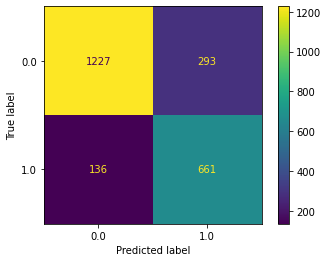

In [35]:
cm = confusion_matrix(y_test, output)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [36]:
cr = classification_report(y_test, output)
print(classification_report(y_test, output))

              precision    recall  f1-score   support

         0.0       0.90      0.81      0.85      1520
         1.0       0.69      0.83      0.75       797

    accuracy                           0.81      2317
   macro avg       0.80      0.82      0.80      2317
weighted avg       0.83      0.81      0.82      2317



## Pass all edges data through model

Data will be displayed for today + 1

In [37]:
import datetime
month = []
weekday=[]
today = datetime.date.today()
tomorrow = today + datetime.timedelta(days=1)
month = [float(tomorrow.month)]
weekday = [float(tomorrow.weekday())]
hours = np.linspace(0,23,24)
month,weekday,hours

([7.0],
 [4.0],
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.]))

Now let us create a dataset with all combinations of edges along with each hour of tomorrow

In [38]:
edges_feat = edges[['uvkey','highway','oneway','length','maxspeed']]
edges_tom = list(product(edges['uvkey'],month, hours, weekday))
edges_tom = pd.DataFrame(edges_tom,columns=['uvkey','Months','Hours','Weekday'])
len(edges_tom)

237120

Now let us extract all the features of the edges

In [39]:
edges_tom_feat = edges_tom.merge(edges_feat,on=['uvkey'],how='inner')
edges_tom_feat['target'] = np.linspace(0,0,len(edges_tom_feat))
edges_tom_feat = maxspeed(edges_tom_feat)
edges_tom_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237120 entries, 0 to 237119
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   uvkey     237120 non-null  object 
 1   Months    237120 non-null  float64
 2   Hours     237120 non-null  float64
 3   Weekday   237120 non-null  float64
 4   highway   237120 non-null  object 
 5   oneway    237120 non-null  bool   
 6   length    237120 non-null  float64
 7   maxspeed  237120 non-null  object 
 8   target    237120 non-null  float64
dtypes: bool(1), float64(5), object(3)
memory usage: 24.6+ MB


Let us process the data to be of the same format as the input to the data model.

In [40]:
edges_encoded = dataencoding(edges_tom_feat)
edges_encoded_x = edges_encoded.drop(['target'],axis=1)
edges_columns = pd.DataFrame(columns = encoded_data.columns).drop(['target'],axis=1)
edges_encoded_x_col = pd.concat([edges_columns,edges_encoded_x]).fillna(0)
edges_input = StandardScaler().fit(edges_encoded_x_col).transform(edges_encoded_x_col)

edges_output = clf.predict(edges_input)

edges_tom_feat['Accident'] = edges_output
edges_tom_feat.head()

,uvkey,Months,Hours,Weekday,highway,oneway,length,maxspeed,target,Accident
0,42421728 42432736 0,7.0,0.0,4.0,secondary,False,86.258,25.0,0.0,1.0
1,42421728 42432736 0,7.0,1.0,4.0,secondary,False,86.258,25.0,0.0,0.0
2,42421728 42432736 0,7.0,2.0,4.0,secondary,False,86.258,25.0,0.0,0.0
3,42421728 42432736 0,7.0,3.0,4.0,secondary,False,86.258,25.0,0.0,0.0
4,42421728 42432736 0,7.0,4.0,4.0,secondary,False,86.258,25.0,0.0,0.0


Let us get the parameters u v and key for converging with the edges GeoPandas Dataset

In [41]:
plotdata = edges_tom_feat[['uvkey','Hours','Accident']]
plotdata['u'] = [int(plotdata['uvkey'][i].split()[0]) for i in range(len(plotdata))]
plotdata['v'] = [int(plotdata['uvkey'][i].split()[1]) for i in range(len(plotdata))]
plotdata['key'] = [int(plotdata['uvkey'][i].split()[2]) for i in range(len(plotdata))]
plotdata = plotdata.drop(['uvkey'],axis=1)
plotdata.head()

,Hours,Accident,u,v,key
0,0.0,1.0,42421728,42432736,0
1,1.0,0.0,42421728,42432736,0
2,2.0,0.0,42421728,42432736,0
3,3.0,0.0,42421728,42432736,0
4,4.0,0.0,42421728,42432736,0


In [42]:
Geo_PlotData= edges.merge(plotdata,on = ['u','v','key'], how = 'left')

In [43]:
type(Geo_PlotData)

geopandas.geodataframe.GeoDataFrame

## Visualising on a map

In [44]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [47]:
def createmap(mydata,title,x,y):
  ax = axs[x,y]

  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.3)

  df = mydata.to_crs(epsg=3857)
  ax = df.plot(ax=ax, cax=cax, column='Accident', cmap='RdYlGn_r', legend=True)
  ax.set_facecolor('black')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(title)
  ax.set_aspect("equal")


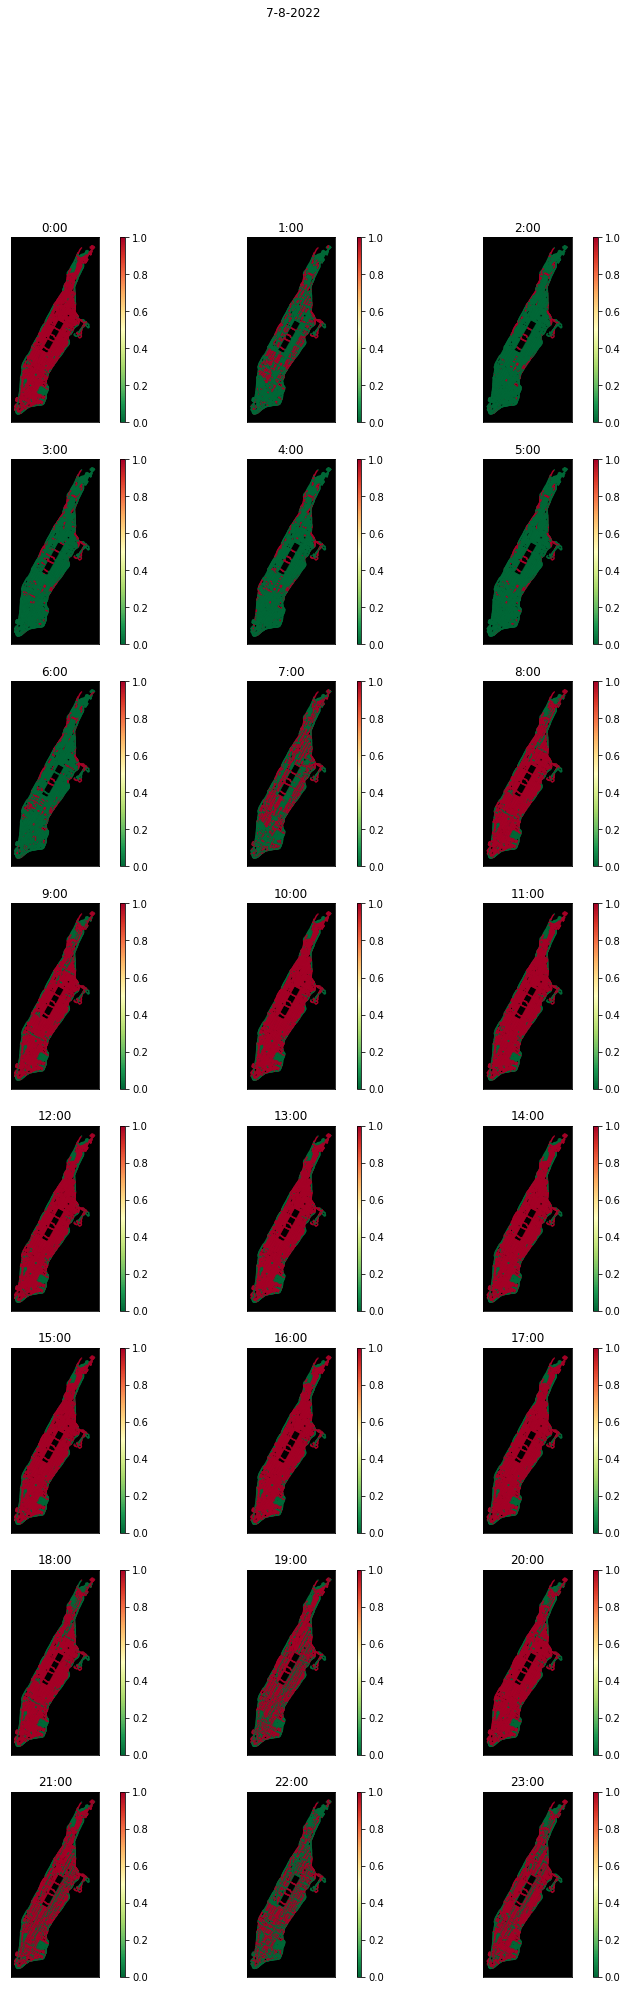

In [48]:
fig, axs = plt.subplots(8,3,figsize = (12,32))
fig.suptitle('{}-{}-{}'.format(tomorrow.month,tomorrow.day,tomorrow.year)) 
for i in range(0,24):
  createmap(Geo_PlotData[Geo_PlotData['Hours'] == i],(str(i)+':00'),i//3,i%3)

As we can see the Accident probabilities are higher during the day in most streets and lesser in the night naturally as a fact of lesser traffic. We can see some areas of the borough have safer streets throughout the day. 

Now let us compare the street safety over one week and see how it changes over the course of one week.